In [1]:
import numpy as np
from tqdm import tqdm, trange

import tensorflow as tf

tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

from nvstatsrecorder.callbacks import NVStats

from xfmers import models
from xfmers import utils
from xfmers import ops

In [2]:
MAX_SEQ_LEN = 128
BATCH_SIZE = 80
BUFFER_SIZE = 10000000
NUM_LAYERS = 6
NUM_HEADS = 12
D_MODEL = NUM_HEADS * 128
FF_UNITS = D_MODEL * 4
DROPOUT = 0.1
WEIGHT_SHARING = False
EFFICIENT_ATTENTION = False
SHARED_QK = False
CONV_FILTER = 1
CONV_PADDING = "same"
ACTIVATION = ops.gelu
REVERSIBLE = False
FUSED_QKV = False

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE *= strategy.num_replicas_in_sync
print("Batch size:", BATCH_SIZE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Batch size: 320


In [3]:
def load_text8(text8_path, num_char=None):
    with open(text8_path, 'r', encoding="utf8") as file:
        data = file.read().replace('\n', '').strip()
    if num_char:
        data = data[:num_char]
    return data.strip()

text_8_train = load_text8("./data/train.txt.raw", num_char=int(1e7))
char_set = list(set(list(text_8_train)))
char_set.sort()
print("Character set:", char_set)
len_corpus = len(text_8_train)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(char_set)+1, char_level=True)
tokenizer.fit_on_texts(["".join(char_set)])

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.num_words], [tokenizer.num_words + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.num_words + 2
print("Vocab size:", VOCAB_SIZE)

# pad to 8
vocab_size_mult = VOCAB_SIZE // 8
vocab_size_r = VOCAB_SIZE % 8
if vocab_size_r > 0:
    VOCAB_SIZE = (vocab_size_mult + 1) * 8
    print("Vocab size padded to:", VOCAB_SIZE, "(performance reasons)")

Character set: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab size: 30
Vocab size padded to: 32 (performance reasons)


In [4]:
def prepare_sequences(corpus, tokenizer, seq_len=512):
    """Tokenize, filter and pad sentences"""
    print("Encoding corpus...")
    corpus = tokenizer.texts_to_sequences([corpus])[0]
    total_words = len(corpus)
    print("Done! Token count:", total_words)
    print("Generating sequences...")
    list_seq = []
    for i in trange(0, total_words-seq_len, seq_len//8):
        seq = START_TOKEN + corpus[i:i+seq_len-2] + END_TOKEN + [corpus[i+seq_len-1]]
        list_seq.append(seq)
    print("Done!")
    return np.asarray(list_seq, dtype="int")

list_seq = prepare_sequences(text_8_train, tokenizer, MAX_SEQ_LEN)

print("Training sequences:", list_seq.shape)

del text_8_train

Encoding corpus...


  4%|▍         | 27218/624992 [00:00<00:05, 108212.08it/s]

Done! Token count: 10000000
Generating sequences...


100%|██████████| 624992/624992 [00:04<00:00, 155903.59it/s]


Done!
Training sequences: (624992, 129)


In [5]:
text_8_val = load_text8("./data/valid.txt.raw")

len_corpus = len(text_8_val)

list_seq_val = prepare_sequences(text_8_val, tokenizer, MAX_SEQ_LEN)

del text_8_val

print("Validation sequences:", list_seq_val.shape)

Encoding corpus...


 12%|█▏        | 36336/312492 [00:00<00:01, 139126.01it/s]

Done! Token count: 4999999
Generating sequences...


100%|██████████| 312492/312492 [00:01<00:00, 179203.25it/s]


Done!
Validation sequences: (312492, 129)


In [6]:
# training

dataset = tf.data.Dataset.from_tensor_slices(({'inputs': list_seq[:,:-1]},
                                              {'outputs': list_seq[:,-1]},))
dataset = dataset.repeat(-1)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(32)
_ = dataset.take(1)

# validation

val_dataset = tf.data.Dataset.from_tensor_slices(({'inputs': list_seq_val[:,:-1]},
                                                  {'outputs': list_seq_val[:,-1]},))
val_dataset = val_dataset.repeat(-1)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE*2)
val_dataset = val_dataset.prefetch(32)
_ = val_dataset.take(1)

In [7]:
with strategy.scope():
    model = models.DecoderTransformer(
        vocab_size=VOCAB_SIZE,
        dec_layers=NUM_LAYERS,
        ff_units=FF_UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        max_seq_len=MAX_SEQ_LEN,
        weight_sharing=WEIGHT_SHARING,
        efficient_attention=EFFICIENT_ATTENTION,
        shared_qk=SHARED_QK,
        activation=ACTIVATION,
        reversible=REVERSIBLE,
        fused_qkv=FUSED_QKV,
    )
    
    learning_rate = utils.NoamSchedule(D_MODEL)
    opt = tf.keras.optimizers.Adam(learning_rate)
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=[utils.bpc])
    model.run_eagerly = False

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [8]:
model.summary()

Model: "DecoderTransformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
PaddingMaskGenerator (PaddingMa (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
TokenPosEmbedding (TokenPosEmbe (None, None, 1536)   245760      inputs[0][0]                     
__________________________________________________________________________________________________
DecoderBlock (TransformerStack) (None, None, 1536)   254923776   PaddingMaskGenerator[0][0]       
                                                                 TokenPosEmbeddin

In [9]:
nv_stats = NVStats(gpu_index=0, interval=2)
time_history = utils.TimeHistory()
callbacks = [
    time_history,
    nv_stats,
]

In [10]:
train_steps = int(list_seq.shape[0]/BATCH_SIZE)
train_steps = 100

with strategy.scope():
    model.fit(dataset, epochs=4, steps_per_epoch=train_steps,
              #validation_data=val_dataset, validation_steps=100,
              verbose=1, callbacks=callbacks)
    
epoch_time = min(time_history.times)
tokens_per_epoch = BATCH_SIZE*train_steps*MAX_SEQ_LEN
print("Tokens/sec:", int(tokens_per_epoch/epoch_time))

Train for 100 steps
Epoch 1/4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 76 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/ta

<Figure size 432x288 with 0 Axes>

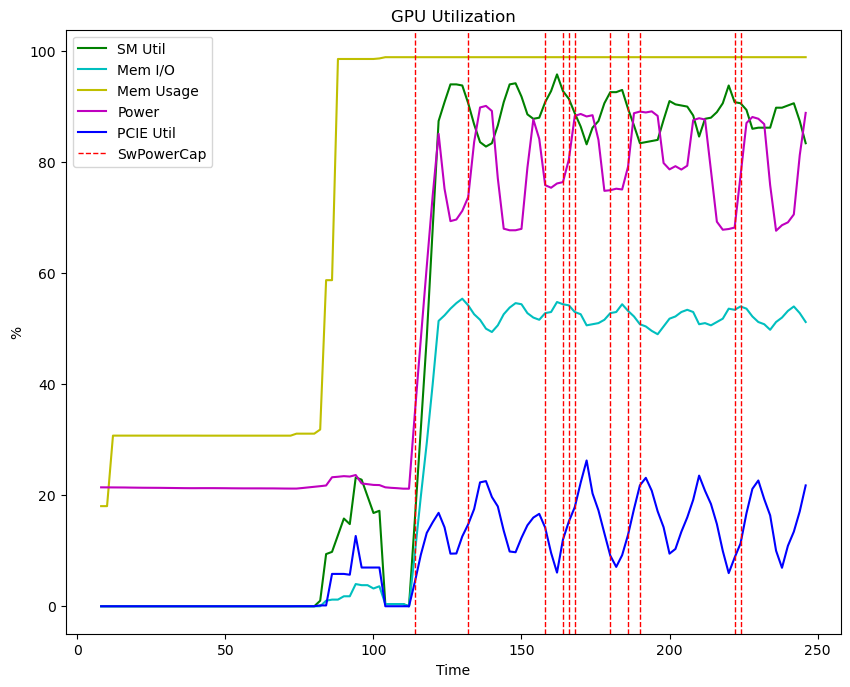

In [11]:
nv_stats_recorder = nv_stats.recorder
nv_stats_recorder.plot_gpu_util(smooth=5)